# GENERALISED COUNTRY-WISE POISSON REGRESSION

##  OVERVIEW

This notebook consist of the <b> Forecasting Module </b> of our Solution, This will consider the data from different sources, including the output of the <b> Markov Module </b> i.e the Stages at which a country is in a particular year. This notebook consist of following 6 Sections: 

<b> 1) Importing Packages  </b> <br> 
<b> 2) Loading Datasets and Preprocessing Steps  </b> <br>
<b> 3) ACF and PACF Plots for determine appropriate Lag  </b> <br> 
<b> 4) Data Visualization </b> <br>
<b> 5) Defining Utility Function for Data Modelling </b> <br>
<b> 6) Model Fitting and Results  </b> <br> 






## 1. IMPORTING PACKAGES

In [20]:
# Importing Packages

import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sn
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error, mean_absolute_error

## 2. LOADING DATASETS AND PREPROCESSING STEPS 

In [21]:
# Reading the dataset

# Australia = pd.read_csv('Data/2nd May/Australia_Covid.csv')
# Austria = pd.read_csv('Data/2nd May/Austria_Covid.csv')
# China = pd.read_csv('Data/2nd May/China_Covid.csv')
# Iceland = pd.read_csv('Data/2nd May/Iceland_Covid.csv')
India = pd.read_csv('Data/12th May/India_data.csv')
# New_Zealand = pd.read_csv('Data/2nd May/New_Zealand_Covid.csv')
# S_korea = pd.read_csv('Data/2nd May/South_Korea_Covid.csv')
# Switzerland = pd.read_csv('Data/2nd May/Switzerland_Covid.csv')

In [22]:
India.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             250 non-null    object 
 1   location         250 non-null    object 
 2   new_cases        102 non-null    float64
 3   new_deaths       102 non-null    float64
 4   total_cases      102 non-null    float64
 5   total_deaths     102 non-null    float64
 6   govt_pol_index   102 non-null    float64
 7   tests_per_thous  101 non-null    float64
 8   Susceptible      250 non-null    float64
 9   Infected         250 non-null    float64
 10  Recovered        250 non-null    float64
 11  I_x              250 non-null    float64
 12  Stages           250 non-null    int64  
dtypes: float64(10), int64(1), object(2)
memory usage: 25.5+ KB


In [43]:
India = India.fillna(0)

In [83]:
def adding_lagged_values(df, lag):
    data = list(df['govt_pol_index'])
    lagged_data = []
    for i in range(lag):
        lagged_data.append(0)
    for i in range(lag, len(data)):
        lagged_data.append(data[i-lag])
    df['lagged_gov_pol_index'] = lagged_data
    df.reset_index()
    return(df)
# print(np.round(lagged_data, 2))

In [84]:
India = adding_lagged_values(India, 14)

In [85]:
India.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  102 non-null    object 
 1   location              102 non-null    object 
 2   new_cases             102 non-null    float64
 3   new_deaths            102 non-null    float64
 4   total_cases           102 non-null    float64
 5   total_deaths          102 non-null    float64
 6   govt_pol_index        102 non-null    float64
 7   tests_per_thous       102 non-null    float64
 8   Susceptible           102 non-null    float64
 9   Infected              102 non-null    float64
 10  Recovered             102 non-null    float64
 11  I_x                   102 non-null    float64
 12  Stages                102 non-null    int64  
 13  lagged_gov_pol_index  102 non-null    float64
dtypes: float64(11), int64(1), object(2)
memory usage: 11.3+ KB


## 4. DATA VISUALIZATION

In [86]:
# Plotting the Confirmed Cases with Date
import matplotlib.pyplot as plt
import seaborn as sns

def plot_data(df, label):
    sns.set(rc = {'figure.figsize':(11,4)})
    df[label].plot(linewidth = 3, color = 'purple')
    df['new_cases'].plot(linewidth = 3, color = 'red')

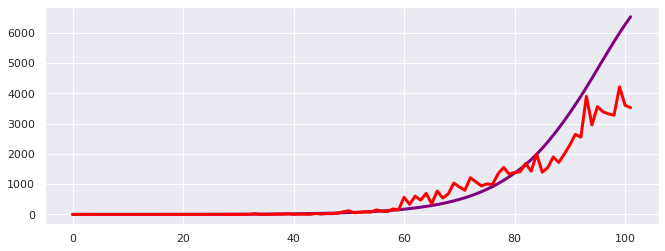

In [87]:
plot_data(India, 'I_x')

In [88]:
India = India.head(102)

## PLOTTING THE CORRELATION GRAPH

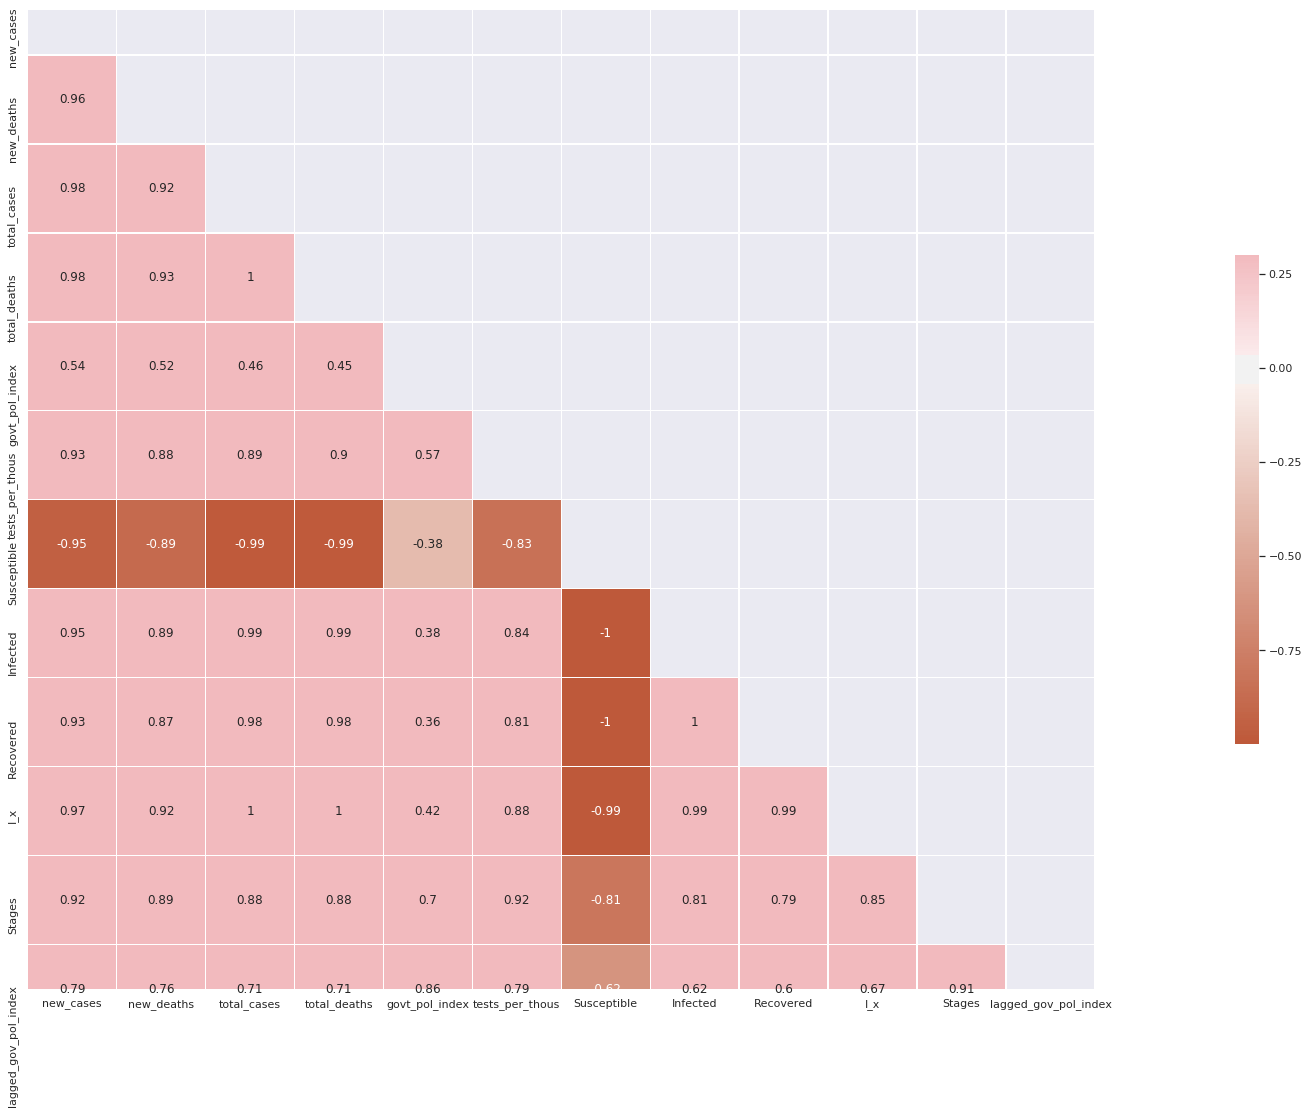

In [90]:
# Compute the correlation matrix
corr = India.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(50, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, annot = True, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## 5. DEFINITION OF UTILITY FUNCTIONS FOR MODELLING DATA

In [94]:
expr = """ new_cases ~ I_x + Stages + lagged_gov_pol_index + tests_per_thous"""


def train_test_split(df,ratio, expr):
    mask = np.random.rand(len(df)) < ratio
    df_train = df[mask]
    df_test = df[~mask]
    print('Training data set length='+str(len(df_train)))
    print('Testing data set length='+str(len(df_test)))
    
#     # Expression for the Model 
#     expr1 = """ cases cases ~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""~ day + month + year   """#Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr2 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests"""
#     expr3 = """cases ~ day + month + year + Daily_tests_per_thousand  + Cum_tests_per_thousand + Daily_tests + popData2018"""

    ## Matrix Formation
    y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
    y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')
    return X_train, y_train, X_test, y_test

def train_model(y_train, X_train):
    model = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()
    print(model.summary())
    return(model)

def predict(model, X_test):
    poisson_predictions = model.get_prediction(X_test)
    #.summary_frame() returns a pandas DataFrame
    predictions_summary_frame = poisson_predictions.summary_frame()
    print(predictions_summary_frame)
    return(predictions_summary_frame['mean'])
    
    
def plot_results(predictions_summary_frame,X_test, y_test, country, label):
    predicted_counts=predictions_summary_frame
    actual_counts = y_test[label]
    fig = plt.figure()
    fig.suptitle(str('Predicted Mean of Covid 19 Cofirmed Cases Count'))
    predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
    actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
    plt.legend(handles=[predicted, actual])
    plt.show()
    return(predicted_counts, actual_counts)
    
def plot_actual_vs_output(predicted_counts, actual_counts):
    plt.clf()
    fig = plt.figure()
    fig.suptitle('Scatter plot of Actual versus Predicted counts')
    plt.scatter(x=predicted_counts, y=actual_counts, marker='.')
    plt.xlabel('Predicted counts')
    plt.ylabel('Actual counts')
    plt.show()

## 6. MODEL TRAINING AND RESULTS

## STEP 1: TEST-TRAIN SPLIT

In [95]:
India_filtered = India[India['total_cases']>3]

In [96]:

X_train, y_train, X_test, y_test = train_test_split(India_filtered,0.7, expr) 
#X_India, y_India, p, q = train_test_split(India,1, expr4)

Training data set length=45
Testing data set length=26


In [97]:
len(X_test)

26

## STEP 2: MODEL TRAINING AND SUMMARY

In [98]:
model = train_model(y_train, X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:              new_cases   No. Observations:                   45
Model:                            GLM   Df Residuals:                       40
Model Family:                 Poisson   Df Model:                            4
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1059.9
Date:                Wed, 13 May 2020   Deviance:                       1786.1
Time:                        22:59:41   Pearson chi2:                 1.77e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                3.4217 

## STEP 3: PREDICTIONS

In [99]:
predictions_frame = (predict(model, X_test)).rolling(3).mean()
# predictions_frame = predictions_frame.fillna(0)

            mean     mean_se  mean_ci_lower  mean_ci_upper
33     38.982252    1.350227      36.423685      41.720545
34     38.988694    1.350433      36.429735      41.727402
38     39.022332    1.351509      36.461329      41.763216
40     39.045417    1.352249      36.483008      41.787799
41     39.058766    1.352678      36.495542      41.802015
44     39.108898    1.354293      36.542607      41.855414
46     64.040375    1.823857      60.563620      67.716720
48     80.383363    2.094346      76.381568      84.594821
52     81.652628    2.131384      77.580254      85.938771
53     82.530949    2.161326      78.401707      86.877668
58    151.176636    3.178676     145.073173     157.536882
59    152.973354    3.197744     146.832547     159.370981
60    185.382518    4.055731     177.601447     193.504493
61    202.817335    3.534128     196.007519     209.863741
65    469.008912    5.262293     458.807587     479.437057
68    867.301036   11.702862     844.664498     890.5442

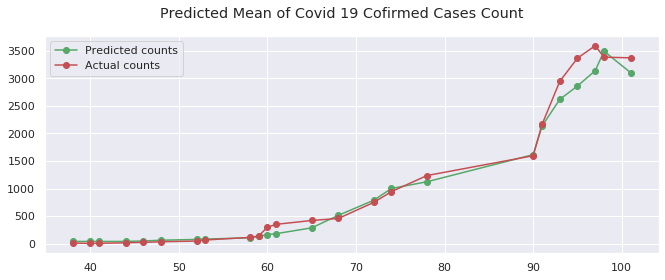

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [100]:
predicted_counts, actual_counts = plot_results(predictions_frame,X_test, y_test.rolling(3).mean(), India, 'new_cases')
scores = [mean_squared_error, r2_score, median_absolute_error, mean_absolute_error]
for i in scores: 
    print(i, i(actual_counts,predicted_counts))